In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [2]:
import torchvision.models as models

# Выбор задачи
Я решил поставить задачу распознавания кошачьих мордочек, а именно разделения фотографий котов на те, где изображен мой кот Кубик, и те, где изображен другой кот. На фотографии морды кота крупным планом хорошо заметны некоторые признаки, по которым можно узнать конкретного кота, например:
- Размер ушей
- Форма ушей
- Форма и цвет области вокруг рта и носа
- Окрас
- Текстура шерсти
В связи с этим, было решено тренировать сверточную нейронную сеть, которая учитывает контекст пикселей и за счет этого находит паттерны на изображениях. Я ожидаю, что нейросеть определит эти особые приметы, и будет эффективно использовать выученные паттерны для того, чтобы отличать Кубика от остальных котов.

# Сбор и подготовка данных
## Какие данные использовались
Для моих целей очень хорошо подходит следующий датасет:

https://github.com/fferlito/Cat-faces-dataset

Датасет содержит 30 тысяч кошачьих мордочек в разрешении 64х64. Изображения уже подготовлены к обучению и никакой дополнительной обработки не потребовалось.\
На своем телефоне я обнаружил 90 фотографий, на которых хорошо видно мордочку Кубика. Я обрезал эти фотографии таким образом, чтобы получились квадратные изображения, на которых большую часть места занимает морда кота. Также я старался оставлять в кадре уши, так как они у него очень большие и потенциально это может быть одним из признаков, которые выучит нейросеть.\
В итоге я имею 90 фотографий Кубика и 1500 фотографий других котов. Так как размер положительного класса в датасете ограничен, каждую эпоху будут тренироваться все фотографии Кубика, к которым применены случайные аугментации, и такое же количество случайно выбранных других котов. Данная техника позволяет тренировать каждую эпоху на отличающихся данных, что будет компенсировать ограниченность датасета.

Датасет тут:
https://drive.google.com/drive/folders/17EBCpztFjJaaDpH3OlbLUQYGVlCB4g38?usp=sharing

## Предобработка и аугментация изображений
Я использую библиотеку **albumentations**, которая реализует такие же трансформации, как  в PyTorch, но работают они быстрее.\
Для загрузки датасета используется готовый класс из PyTorch, но в связи с особенностями реализации библиотеки **albumentations** мне пришлось создать класс-наследник и переопределить в нем метод получения изображения по индексу.

In [3]:
from typing import Tuple, Any

class AlbumentationsImageFolder(ImageFolder):
    def __init__(self, path, transforms):
        super(AlbumentationsImageFolder, self).__init__(path, transform=transforms)
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = np.array(sample)
            sample = self.transform(image=sample)
        if self.target_transform is not None:

            target = self.target_transform(target)

        return sample['image']/1.0, target

Для загрузки случайных трансформаций исходных изображений и обеспечения сбалансированности выборки реализован загрузчик данных и его итератор.

In [4]:
from sklearn.utils import shuffle


class MyDataLoaderIterator():
  def __init__(self, loader):
    self.loader = loader

  def __next__(self):
    labels = []
    data = []
    for kubik_index in range(self.loader.kubik_len):
        #print(kubik_index)
        for i in range(self.loader.repeats):
            kubik = self.loader.dataset[kubik_index]
            data.append(kubik[0])
            labels.append(kubik[1])
    #print('kubik sampled')
    rng = np.random.default_rng()
    indices = rng.choice(np.arange(self.loader.kubik_len, len(self.loader.dataset)), size=self.loader.kubik_size, replace=False)
    for not_kubik_index in indices:
        not_kubik = self.loader.dataset[not_kubik_index]
        data.append(not_kubik[0])
        labels.append(not_kubik[1])
    #print('rest sampled')
    data, labels = shuffle(data, labels)
    return torch.stack(data), torch.tensor(labels)
    raise StopIteration

class MyDataLoader():
    def __init__(self, dataset, kubik_len, repeats=5):
        self.dataset = dataset
        self.kubik_len = kubik_len
        self.repeats = repeats
        self.kubik_size = self.kubik_len * self.repeats
        
    def __iter__(self):
        return MyDataLoaderIterator(self)

!pip install -U git+https://github.com/albumentations-team/albumentations

In [5]:
import albumentations
import albumentations.pytorch as atorch

Изображения для тренировки приводятся к одинаковому размеру, после чего немного подрезаются (случайным образом), изображение сдвигается, и накладывается шум случайного вида.\
Изображения для тестов просто приводятся к размеру и подрезаются.

In [6]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(64, 64),
    albumentations.RandomCrop(55, 55),
    atorch.ToTensorV2()
])

albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(64, 64), 
    albumentations.RandomCrop(55, 55),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    atorch.ToTensorV2()
])

cats_train = AlbumentationsImageFolder('./cats/train', albumentations_transform_oneof)
cats_test = AlbumentationsImageFolder('./cats/test', albumentations_transform)

In [7]:
len(cats_train)

1060

In [8]:
len(cats_test)

530

In [9]:
cats_train[0][0]

tensor([[[124., 111., 117.,  ...,  70.,  84.,  86.],
         [ 96., 111., 120.,  ...,  82.,  88.,  93.],
         [ 85.,  70.,  85.,  ...,  75.,  74.,  89.],
         ...,
         [ 60.,  80.,  73.,  ..., 103., 101.,  82.],
         [ 45.,  77.,  46.,  ..., 139., 114., 120.],
         [ 32.,  52., 102.,  ..., 169., 152., 104.]],

        [[113.,  89.,  98.,  ...,  34.,  52.,  45.],
         [ 67.,  86.,  96.,  ...,  45.,  52.,  54.],
         [ 58.,  43.,  61.,  ...,  57.,  59.,  56.],
         ...,
         [ 63.,  73.,  70.,  ..., 103.,  94.,  74.],
         [ 50.,  64.,  50.,  ..., 130., 101., 113.],
         [ 22.,  44.,  96.,  ..., 166., 146., 105.]],

        [[ 93.,  92.,  76.,  ...,  29.,  48.,  34.],
         [ 62.,  74.,  85.,  ...,  40.,  40.,  53.],
         [ 38.,  44.,  50.,  ...,  45.,  48.,  49.],
         ...,
         [ 50.,  73.,  74.,  ...,  77.,  89.,  64.],
         [ 55.,  51.,  27.,  ..., 130.,  89.,  94.],
         [ 34.,  37.,  84.,  ..., 154., 146.,  82.]]]

In [10]:
def plot_image(image, truth=None, pred=None):
    if truth is not None and pred is not None:
      if truth == 0:
        truth = 'Kubik'
      else:
        truth = 'Not Kubik'
      if pred == 0:
        pred = 'Kubik'
      else:
        pred = 'Not Kubik'
      plt.title('truth: ' + truth + ', pred: ' + pred)
    plt.imshow(image.int().permute(1,2,0))
    plt.show()

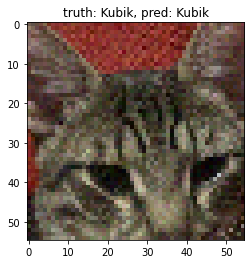

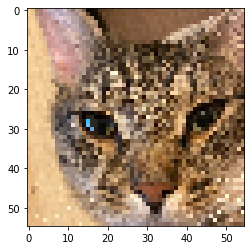

In [11]:
plot_image(cats_train[0][0], 0, 0)
plot_image(cats_test[1][0])

In [12]:
kubik_label = cats_train[0][1]
not_kubik_label = 1 - kubik_label

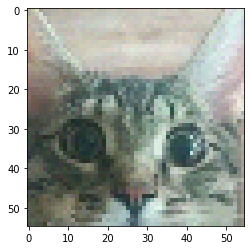

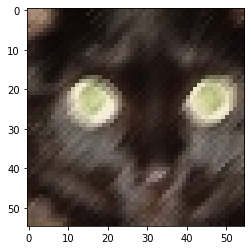

In [13]:
kubik_train_len = 60
plot_image(cats_train[3][0])
plot_image(cats_train[kubik_train_len][0])

In [14]:
kubik_test_len = 30
train_loader = MyDataLoader(cats_train, kubik_train_len)
test_loader = MyDataLoader(cats_test, kubik_test_len)
#iter(train_loader).__next__()

# Обучение нейросетей

Вспомогательный класс, который строит график.

In [15]:
from IPython.display import clear_output

class EpochPlotter():
  def __init__(self):
    self.current_epoch = 0
    self.epochs_axis = []
    self.train_accuracies = []
    self.test_accuracies = []

  def __call__(self, train_accuracy, test_accuracy):
    self.epochs_axis.append(self.current_epoch)
    self.train_accuracies.append(train_accuracy)
    self.test_accuracies.append(test_accuracy)
    self.current_epoch += 1

    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.plot(self.epochs_axis, self.train_accuracies, label="train accuracy")
    plt.plot(self.epochs_axis, self.test_accuracies, label="test accuracy")
    plt.grid()
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Функция тренировки

In [51]:
def train_model(model_, epochs=50):
    device = torch.device('cuda')
    model = model_.to(device)
    import time
    loss_fn = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    plotter = EpochPlotter()
    total_train = 0
    total_eval = 0
    for epoch in range(epochs):

      success_pred = 0

      model.train()

      part_len = 10
      data, labels = iter(train_loader).__next__()
      data, labels = data.to(device), labels.to(device)

      train_start = time.time()
      for i in range(int(len(labels)/part_len)):
        cur = part_len*i
        next = part_len*(i+1)
        data_part = data[cur:next]
        labels_part = labels[cur:next]

        y_pred = model(data_part)
        loss = loss_fn(y_pred, labels_part)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_classes = y_pred.argmax(axis=1)
        success_pred += (y_classes == labels_part).sum()

      epoch_train = time.time() - train_start
      total_train += epoch_train


      train_accuracy = success_pred/len(labels)

      model.eval()
      test_count = 0

      with torch.no_grad():
          part_len = 10
          data, labels = iter(test_loader).__next__()
          data, labels = data.to(device), labels.to(device)
          eval_start = time.time()
          for i in range(int(len(labels)/part_len)):
              cur = part_len*i
              next = part_len*(i+1)
              data_part = data[cur:next]
              labels_part = labels[cur:next]
              y_pred = model(data_part)
              test_count += (y_pred.argmax(axis=1) == labels_part).sum()
      epoch_eval = time.time() - eval_start
      total_eval += epoch_eval


      test_acc = test_count/len(labels)
      plotter(train_accuracy.item(), test_acc.item())
      print('epoch train: ', epoch_train)
      print('epoch eval: ', epoch_eval)

    print('Total train time:', total_train)
    print('Total eval time:', total_eval)

## Готовая архитектура
В качестве готовой архитектуры была выбрана **SqueezeNet**, так как она специально разрабатывалась с малым числом параметров, и с расчетом на быстрое обучение и малый размер модели. Для простой задачи распознавания одного кота она должна подойти.

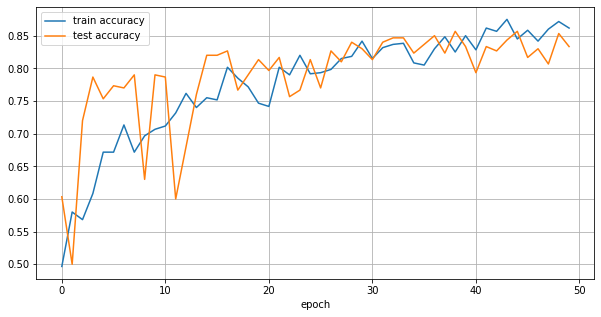

epoch train:  2.352936029434204
epoch eval:  0.1369471549987793
Total train time: 116.10041809082031
Total eval time: 8.696363925933838


In [52]:
model = models.squeezenet1_1(pretrained=False)
train_model(model)

Видим, что несмотря на малый размер данных, сеть всего за несколько эпох вышла на результат около 80%, и за примерно за 30 эпох натренировалась до точности 85%.\
Результат неплохой, но можно лучше. Мое предположение - сеть заточена под imageNet, и из коробки, без дополнительной настройки, не покажет отличных результатов для другой задачи.\
Обучается сеть сравнительно быстро, на одну эпоху тренировки уходит около двух секунд.

## Своя архитектура
Сначала я решил сделать максимально простую архитектуру из нескольких слоев:
- Свертка для поиска особых черт кота.
- Пулинг для генерализации, повышения устойчивости к небольшим сдвигам изображения. При тренировке часто используются одни и те же изображения, но немного сдвинутые, и данный слой необходим.
- Линейный слой.
Но такая сеть показала не очень хорошие результаты.

Я решил добавить функцию активации и слой батч нормализации. Это небольшое улучшение дало прирост примерно в 20% уже на первых нескольких эпохах! 

In [53]:
class MyConvNN(nn.Module):
    def __init__(self):
        super(MyConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, padding='same')
        self.activ = nn.ReLU()
        self.norm = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear = nn.LazyLinear(10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ(x)
        x = self.norm(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

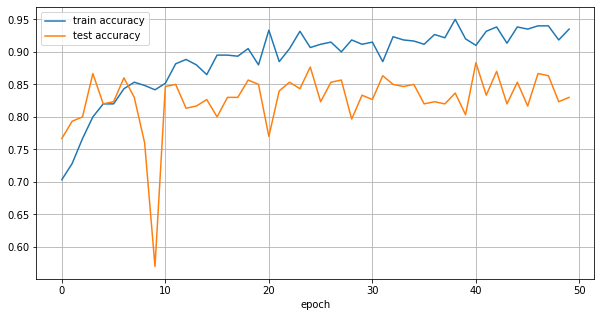

epoch train:  0.20207905769348145
epoch eval:  0.017993688583374023
Total train time: 7.151504755020142
Total eval time: 0.8847265243530273


In [54]:
model = MyConvNN()
train_model(model)

Данная простая архитектура в моей задаче показывает себя гораздо лучше, чем **SqueezeNet**:
- Гораздо быстрее тренируется - доли секунды на эпоху вместо двух секунд. Итоговая разница во времени огромная.
- Показывает лучшие результаты - показала такой же результат как сквиз за 30 эпох, но на первых же нескольких эпохах.

Как было сказано выше, мое мнение - сквизнет просто не отпимизирован из коробки для подобной задачи, поэтому простая архитектура тут выигрывает показывает такие же результаты гораздо раньше, и еще и тренируется быстрее за счет своей простоты.

На графике видно, что после нескольких первых эпох дальнейшего улучшения почти не происходит. Дальше тренировать смысла нет.

# Приложение
Тут можно посмотреть на котиков.

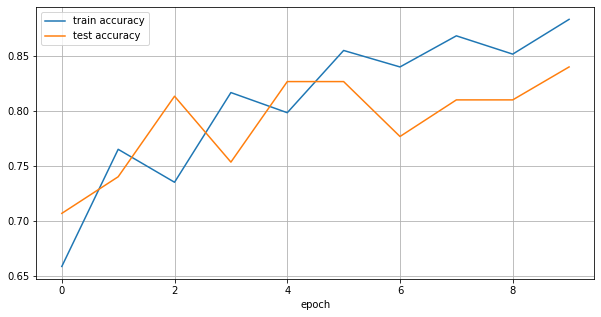

epoch train:  0.18030142784118652
epoch eval:  0.06582808494567871
Total train time: 2.9256629943847656
Total eval time: 0.34655308723449707


In [55]:
model = MyConvNN()
train_model(model, 10)

In [80]:
data, labels = iter(test_loader).__next__()
device = torch.device('cuda')
data, labels = data.to(device), labels.to(device)
y_pred = model(data)
y_pred = y_pred.argmax(axis=1)

In [81]:
round(float((y_pred == labels).sum()/len(labels)), 2)

0.84

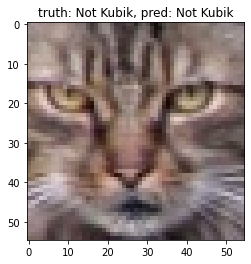

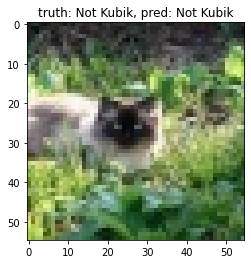

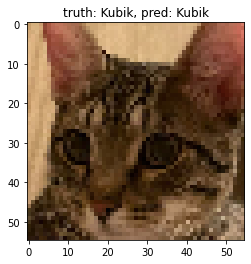

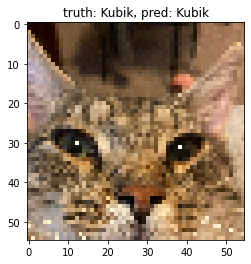

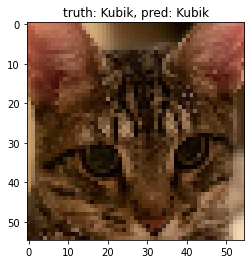

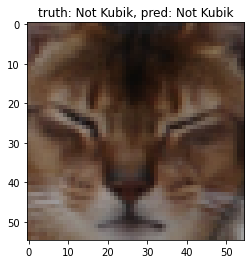

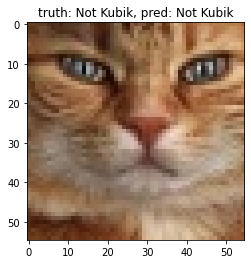

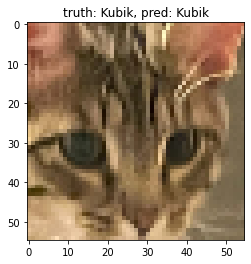

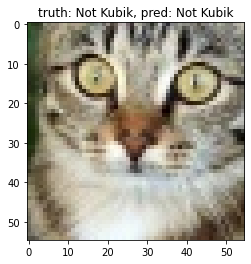

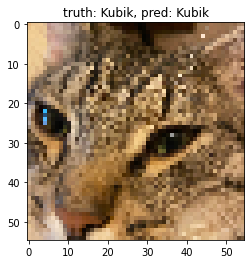

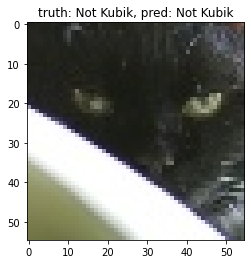

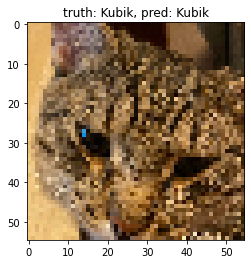

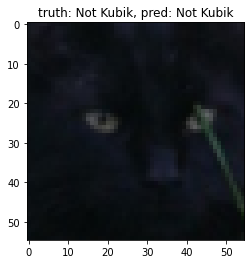

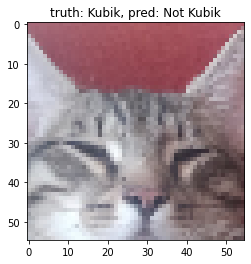

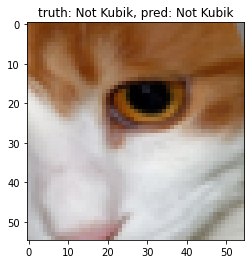

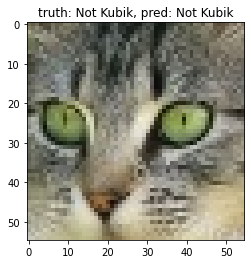

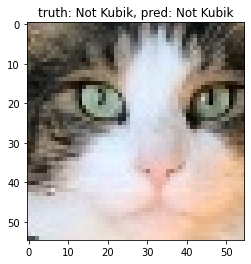

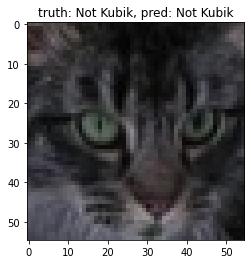

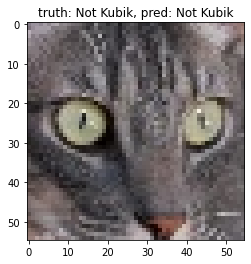

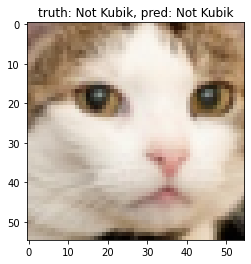

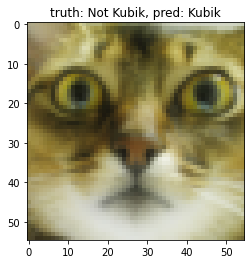

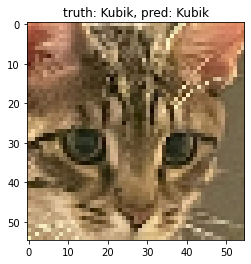

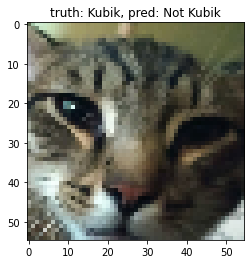

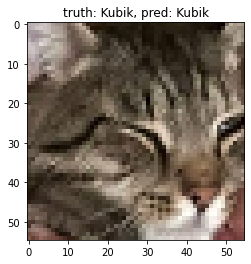

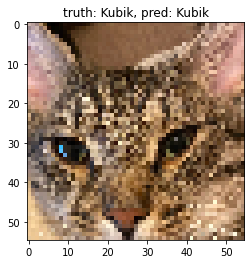

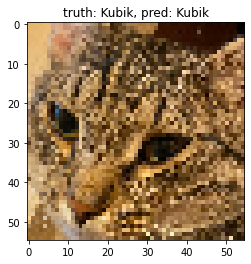

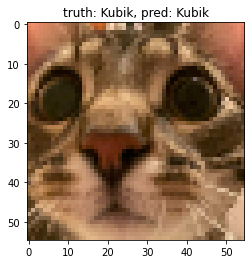

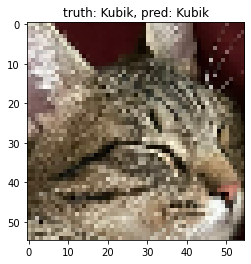

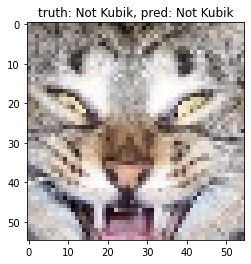

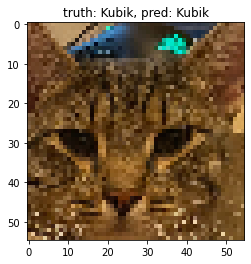

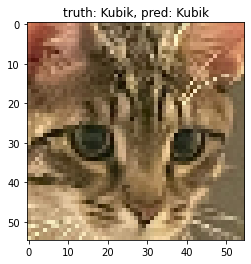

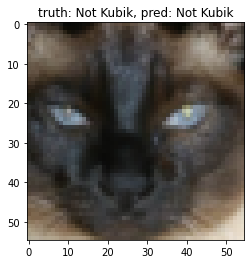

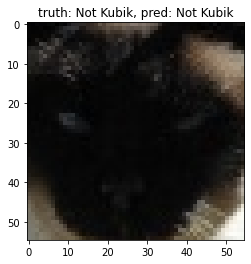

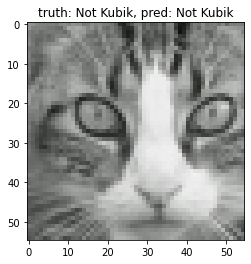

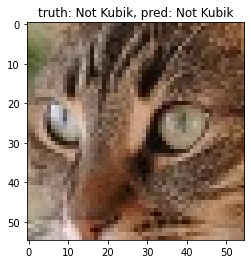

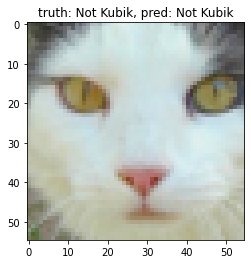

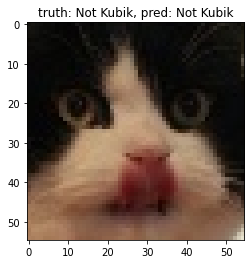

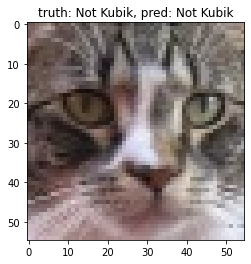

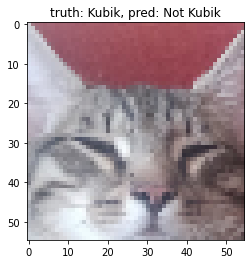

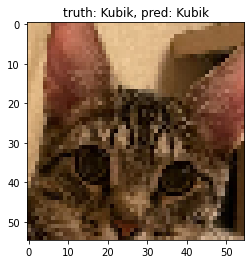

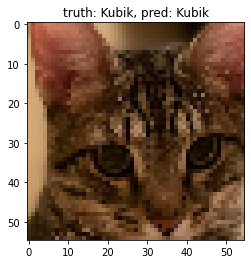

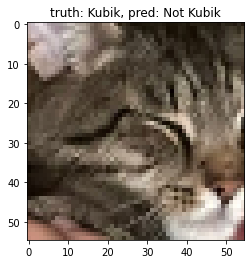

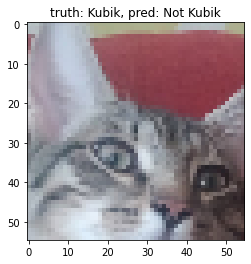

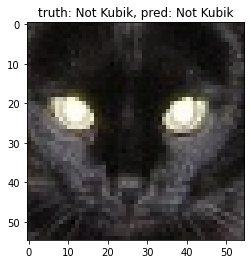

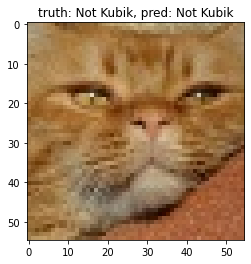

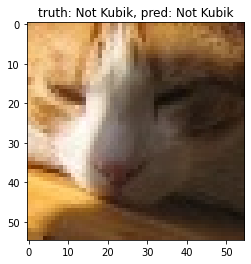

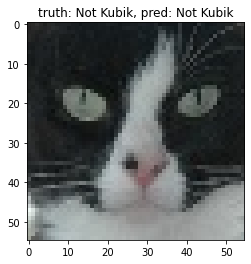

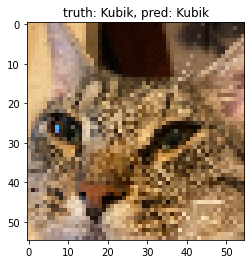

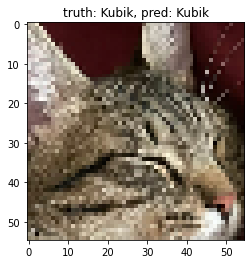

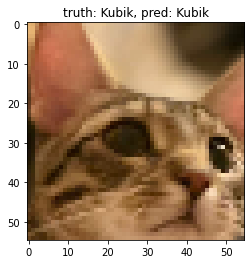

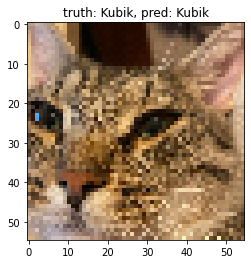

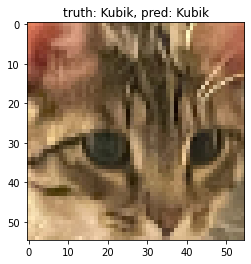

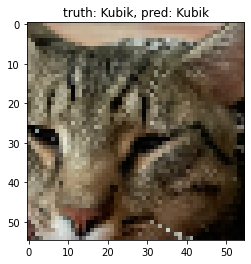

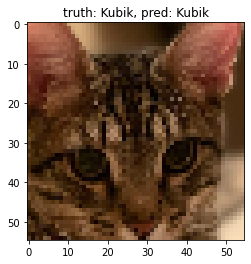

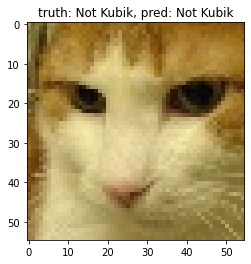

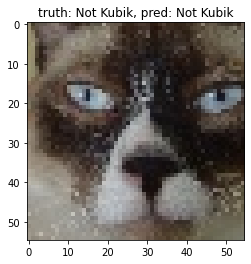

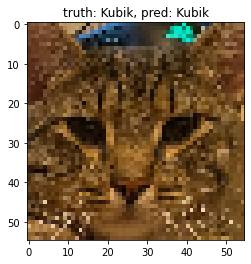

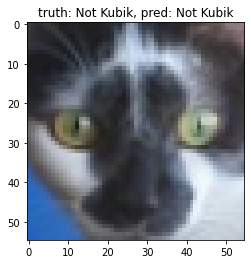

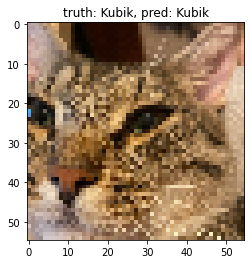

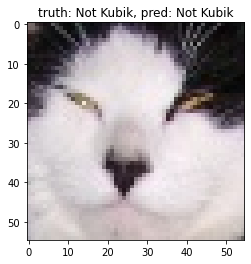

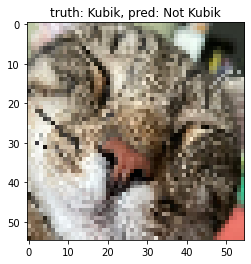

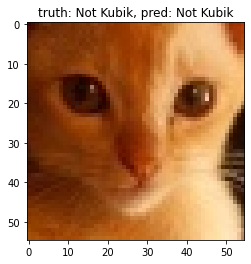

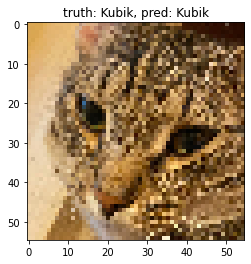

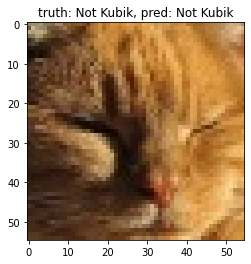

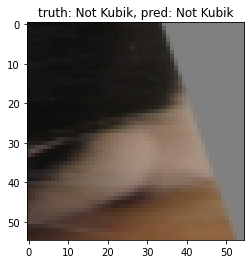

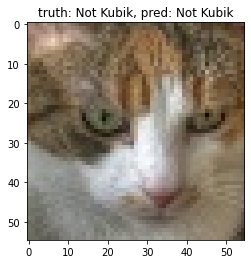

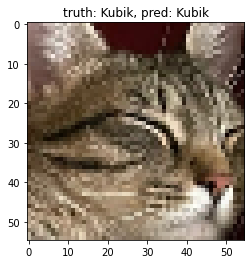

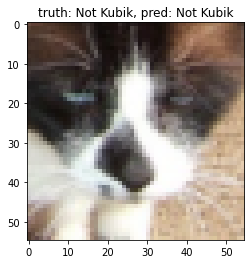

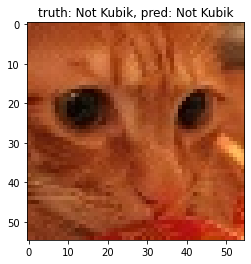

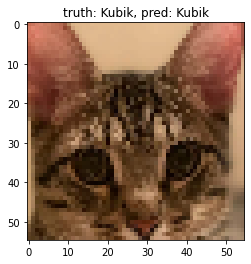

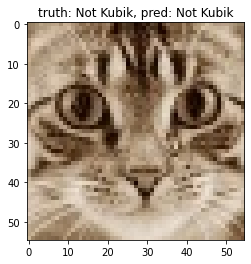

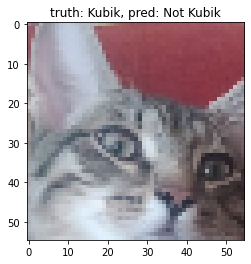

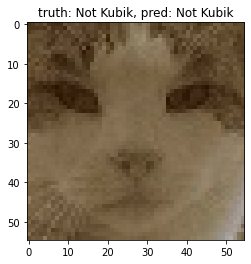

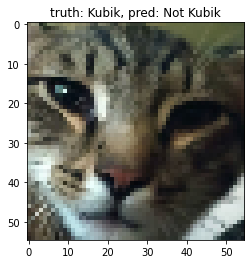

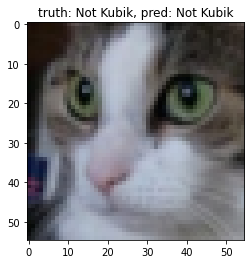

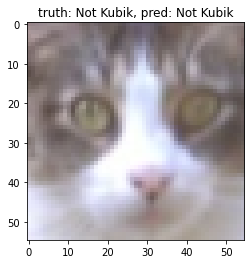

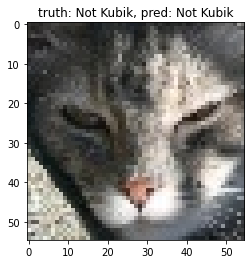

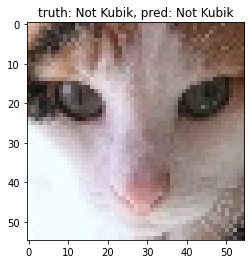

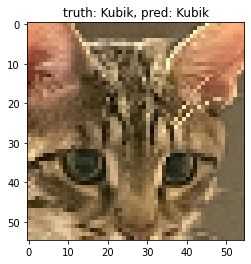

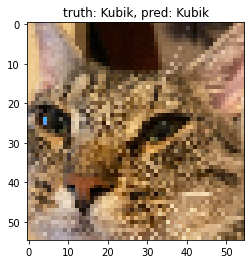

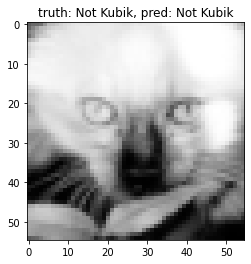

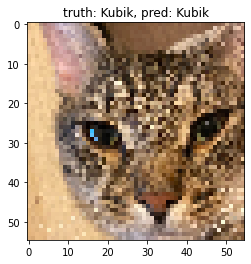

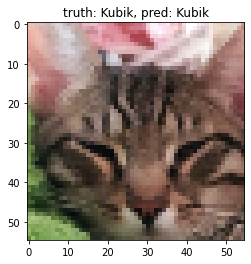

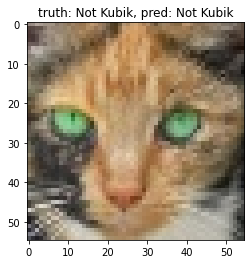

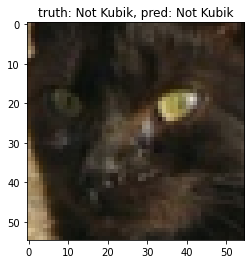

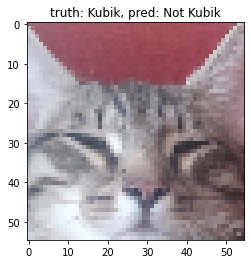

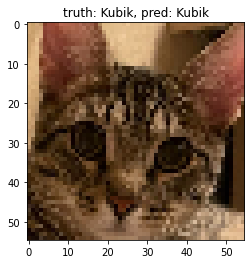

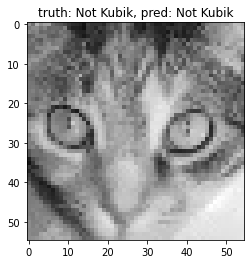

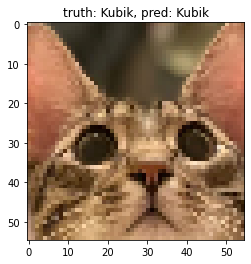

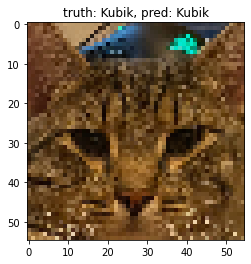

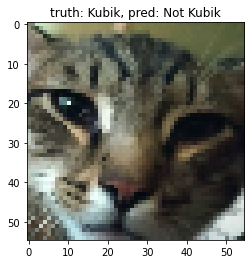

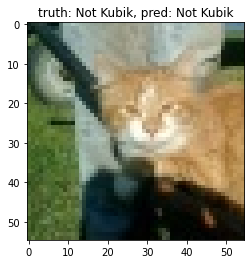

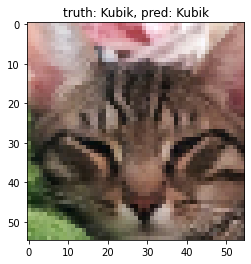

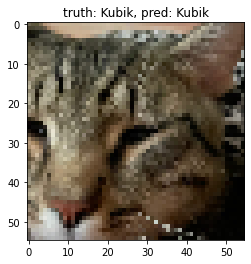

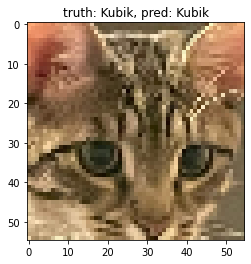

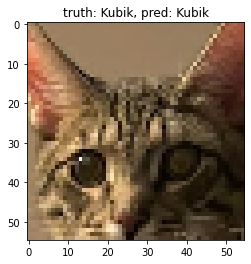

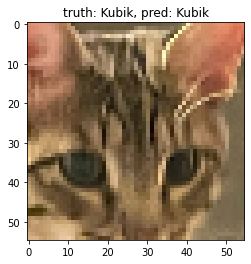

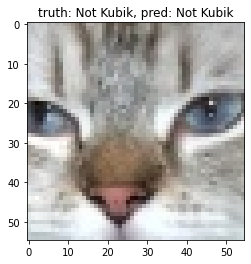

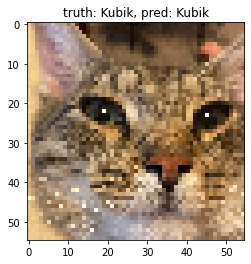

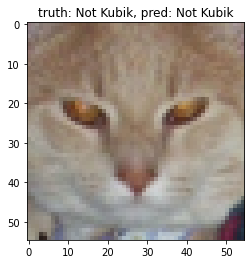

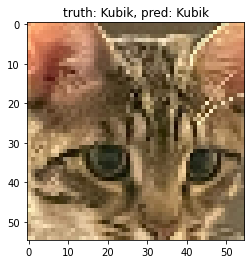

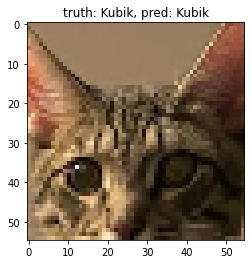

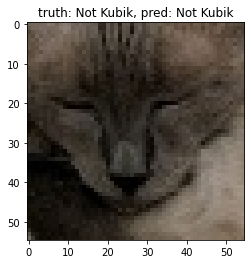

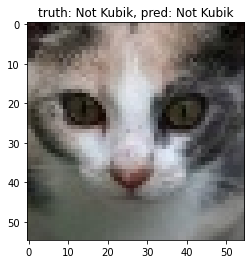

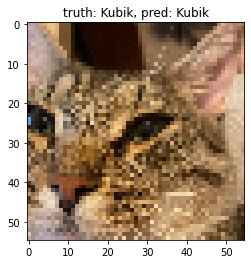

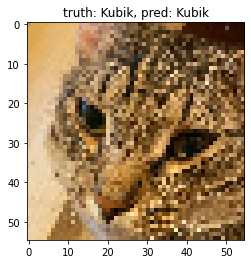

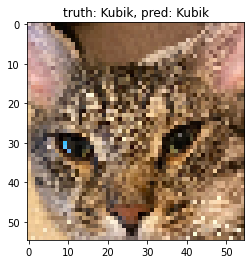

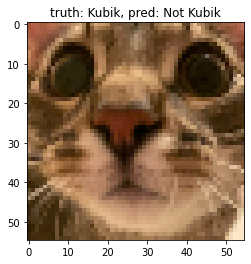

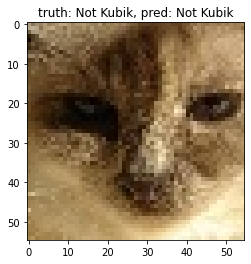

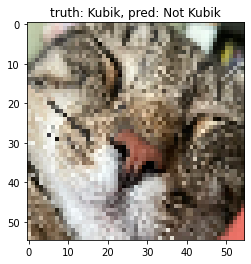

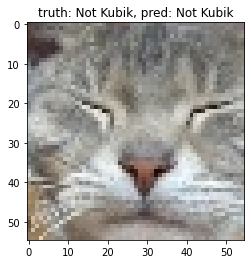

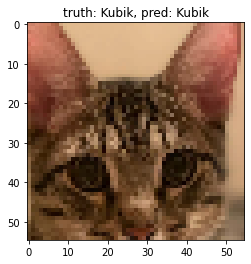

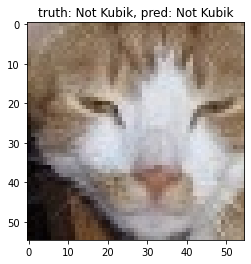

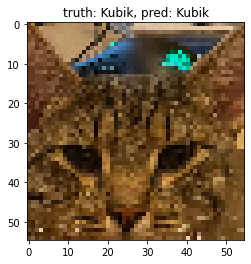

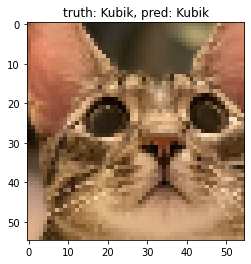

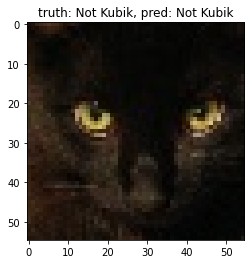

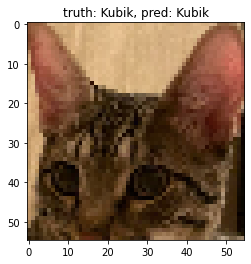

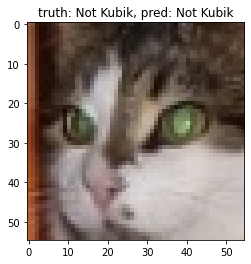

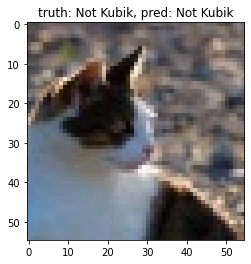

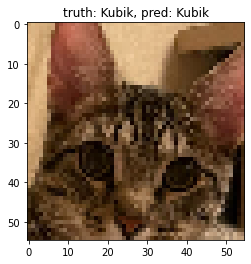

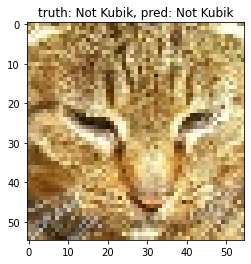

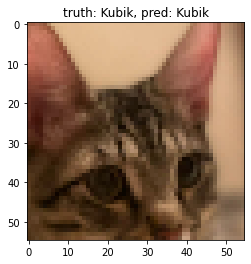

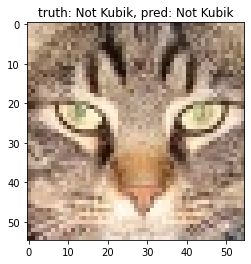

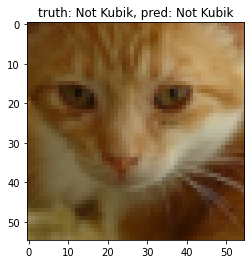

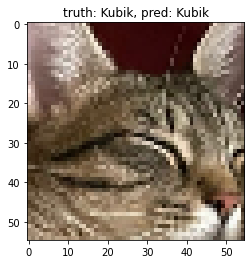

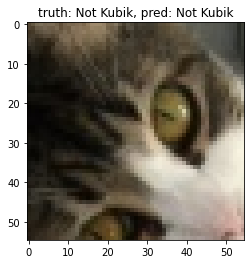

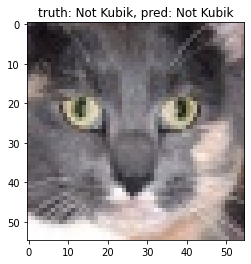

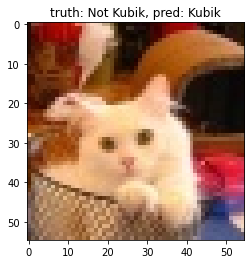

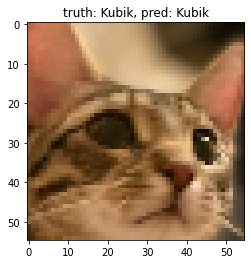

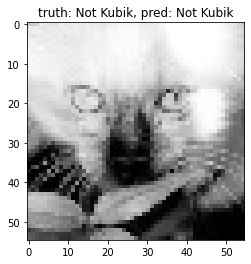

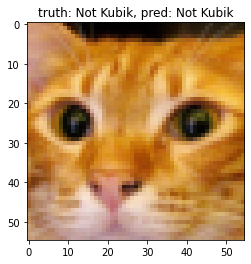

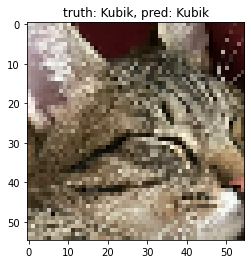

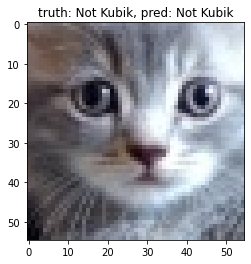

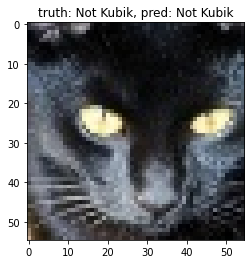

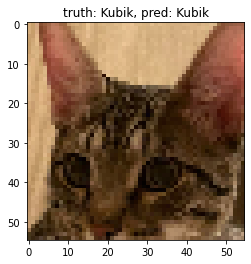

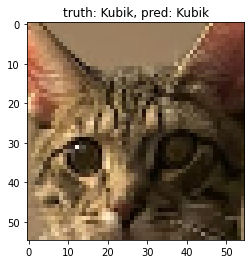

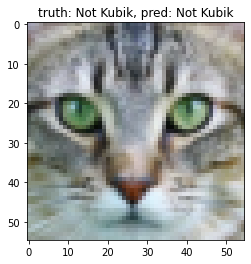

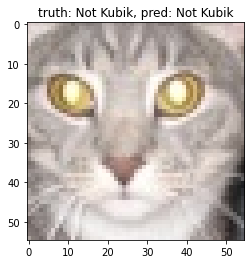

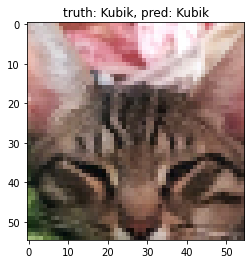

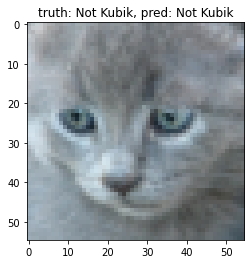

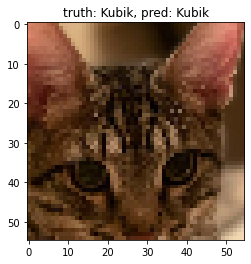

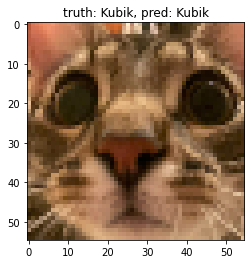

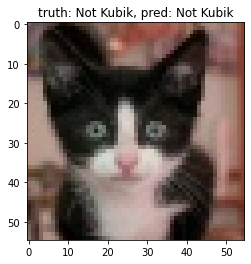

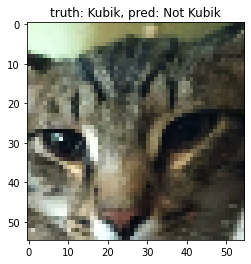

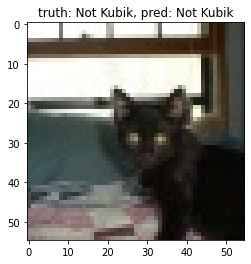

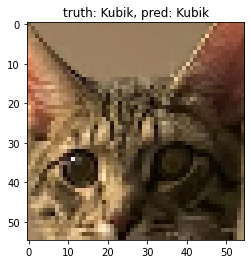

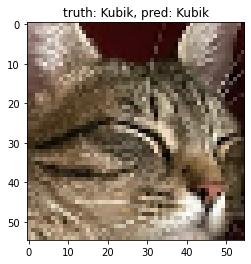

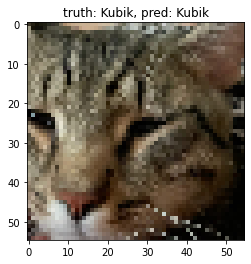

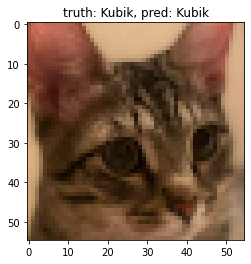

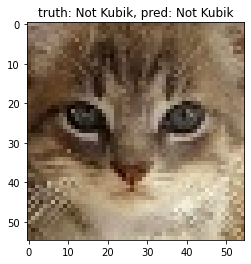

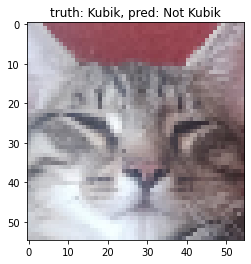

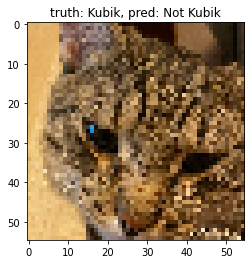

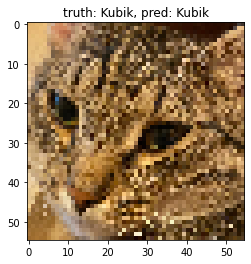

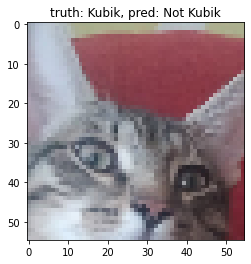

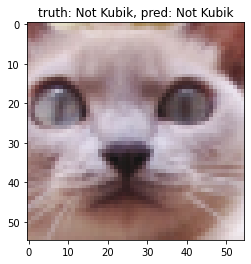

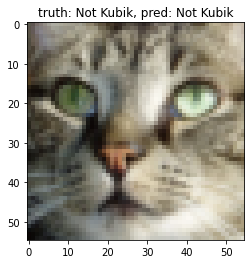

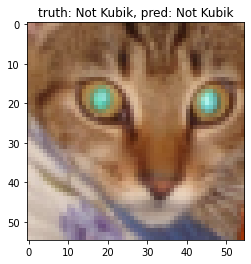

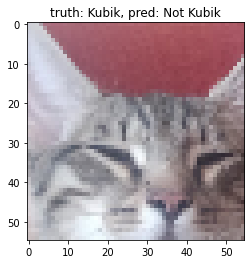

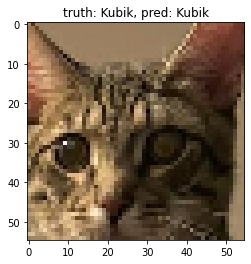

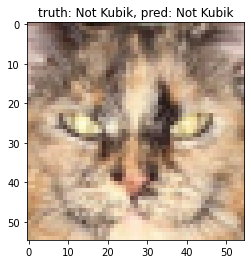

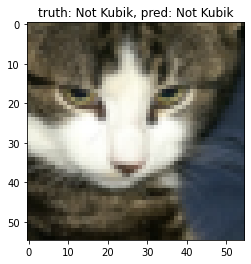

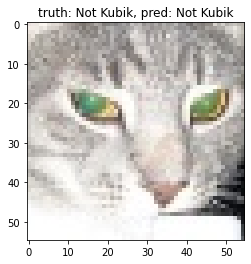

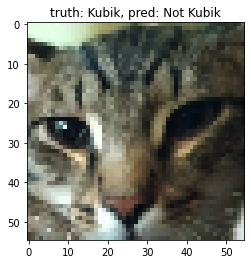

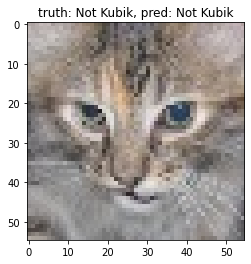

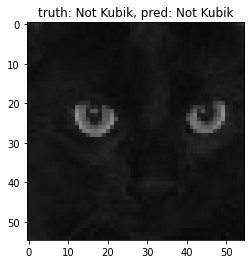

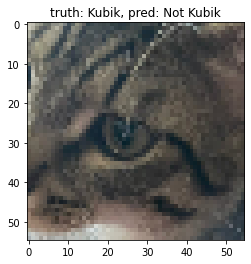

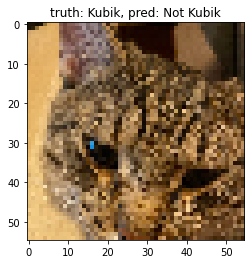

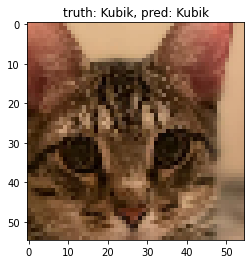

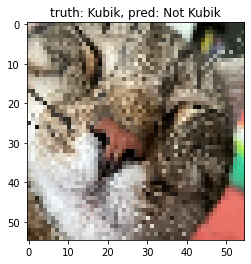

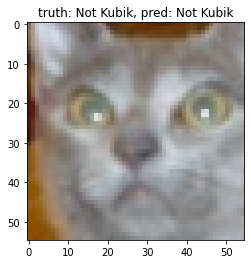

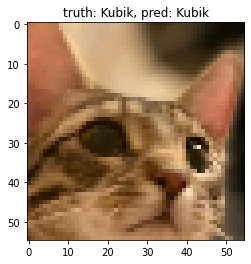

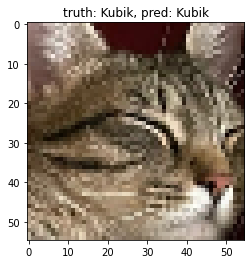

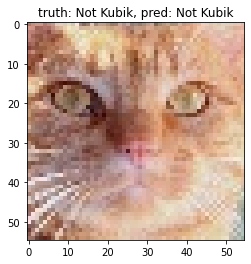

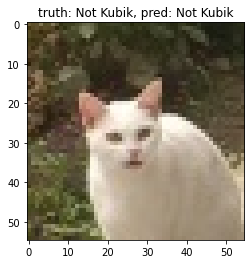

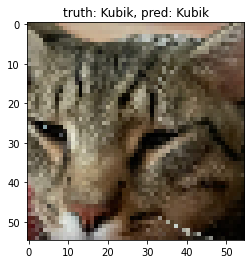

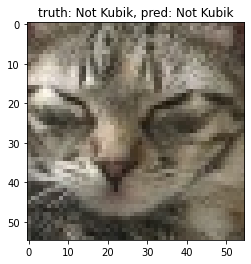

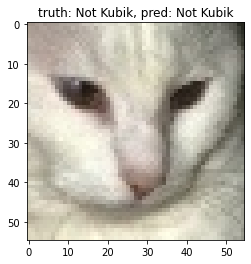

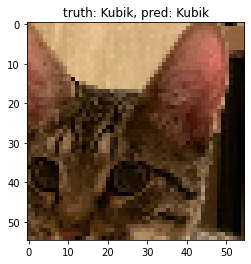

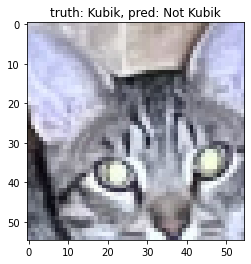

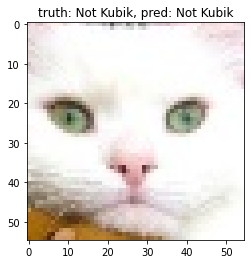

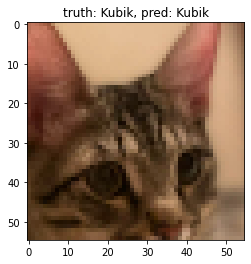

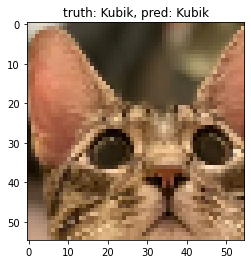

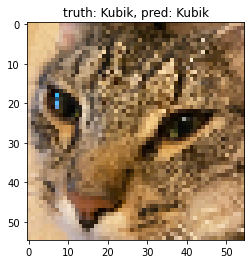

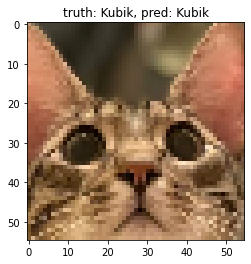

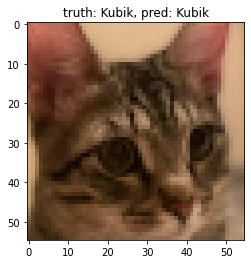

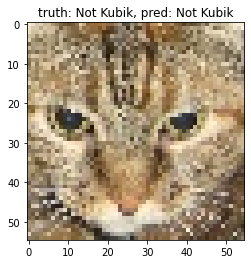

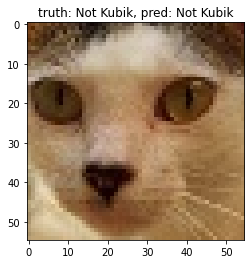

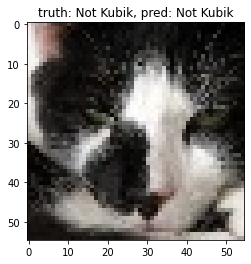

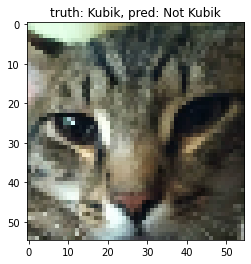

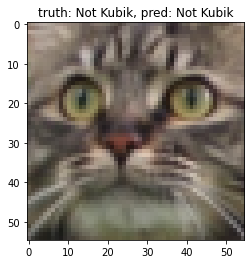

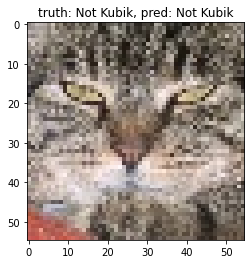

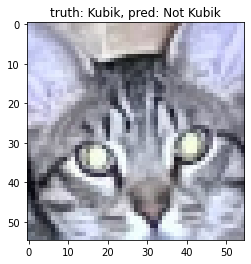

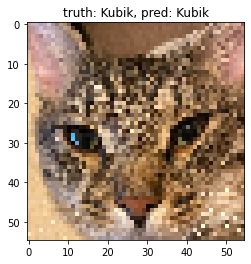

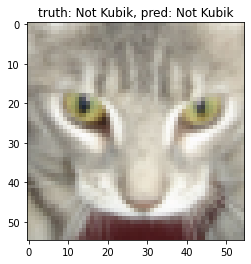

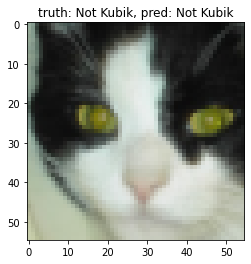

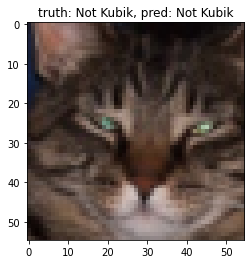

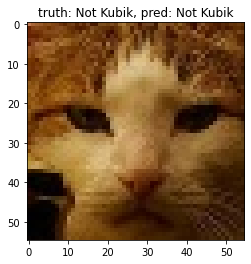

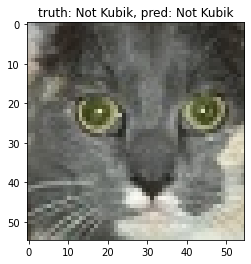

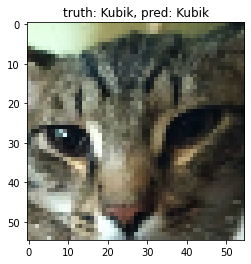

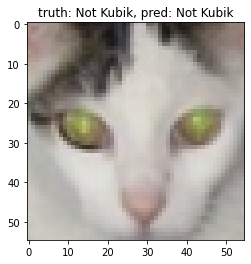

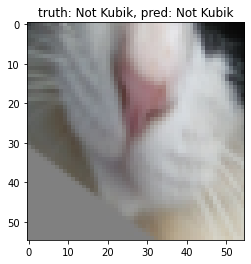

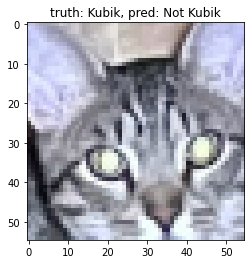

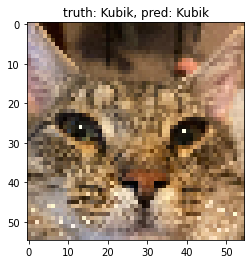

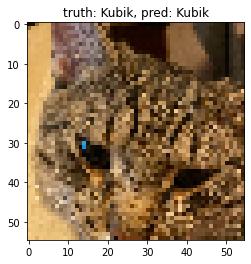

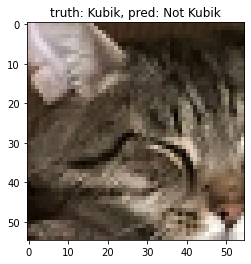

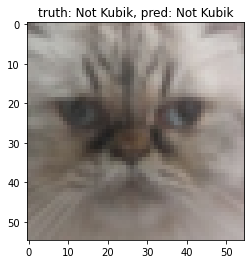

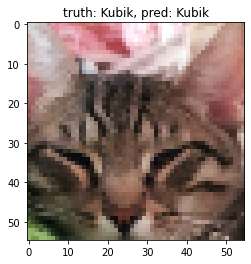

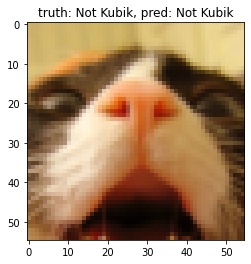

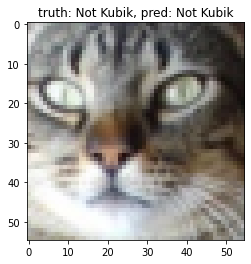

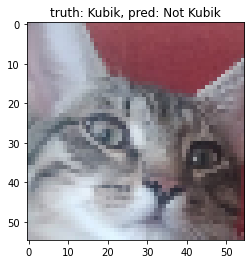

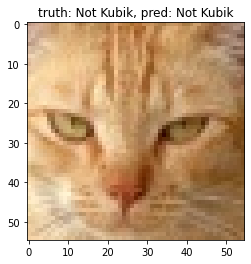

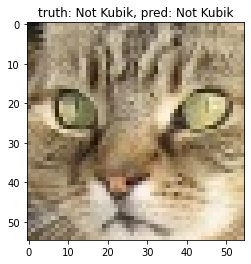

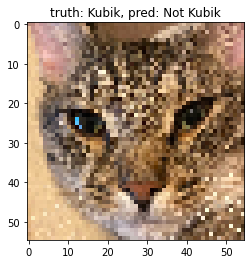

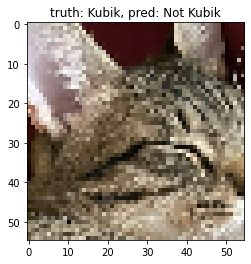

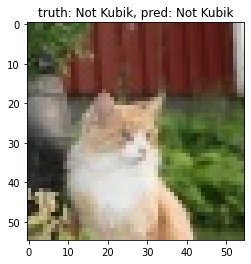

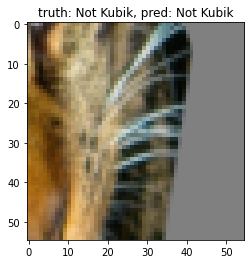

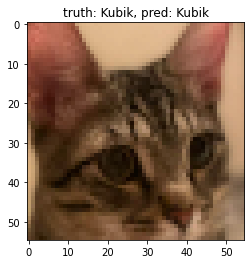

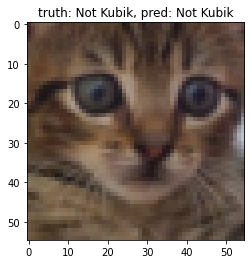

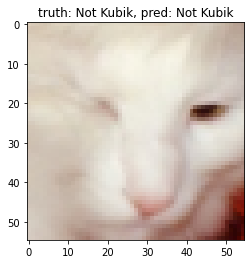

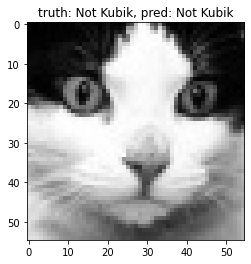

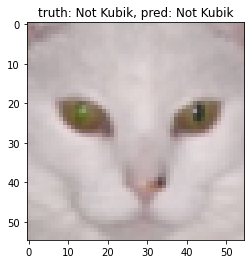

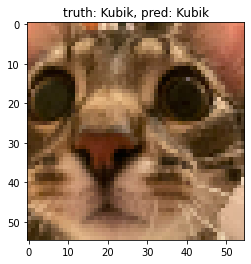

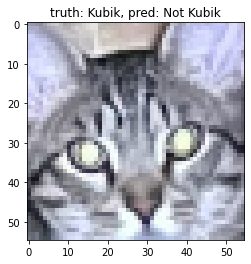

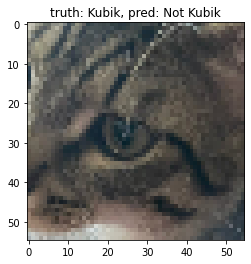

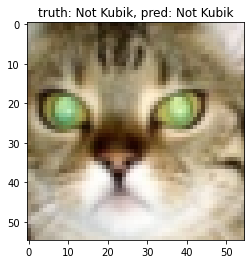

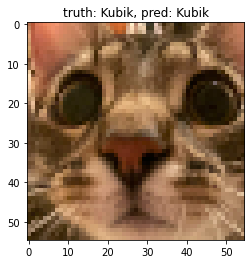

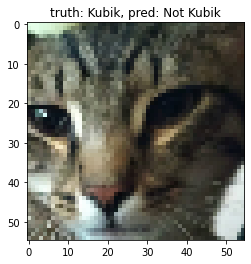

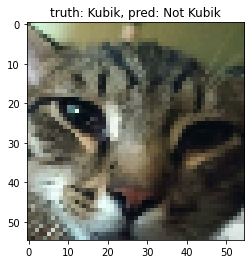

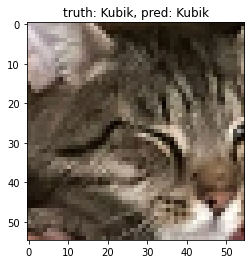

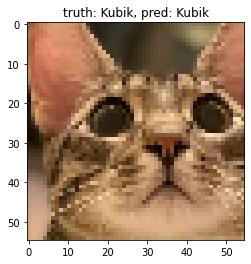

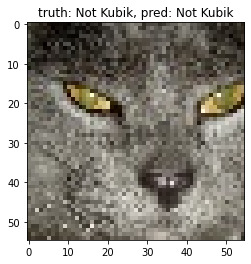

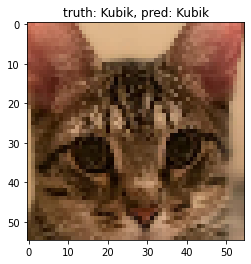

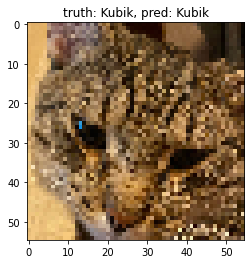

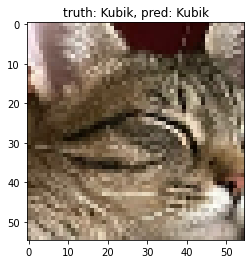

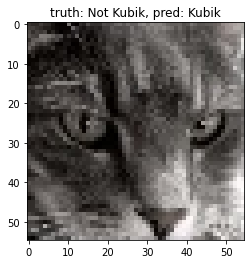

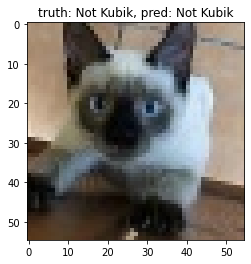

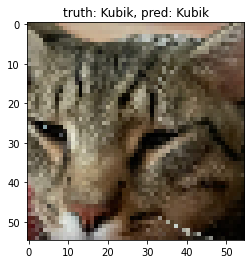

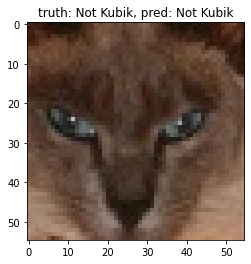

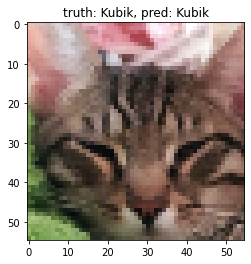

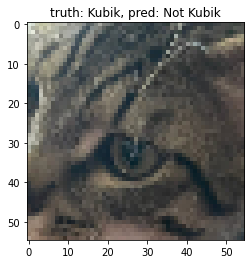

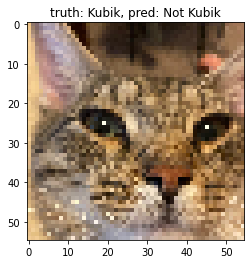

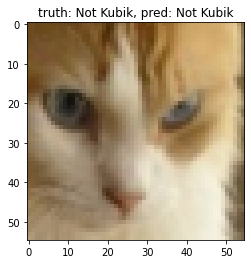

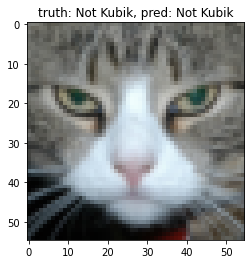

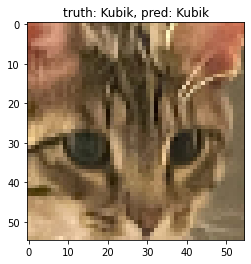

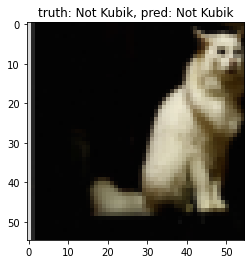

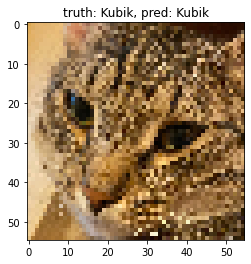

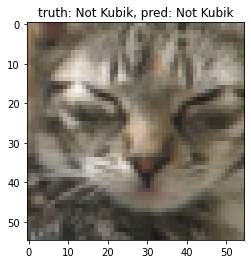

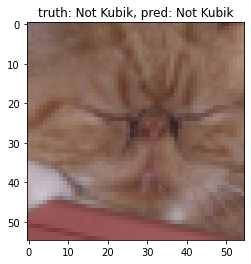

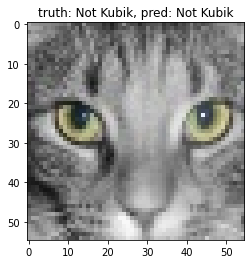

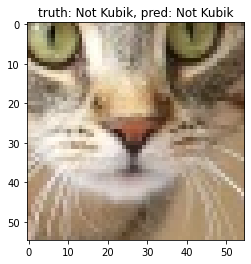

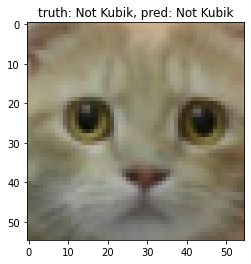

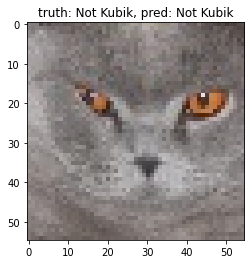

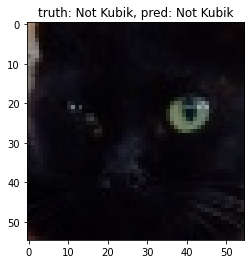

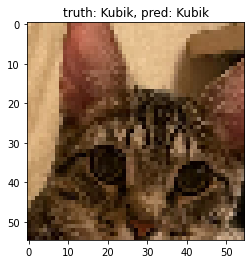

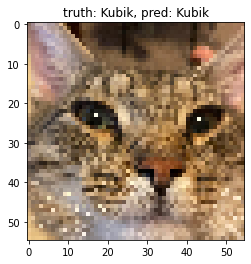

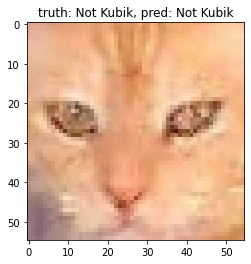

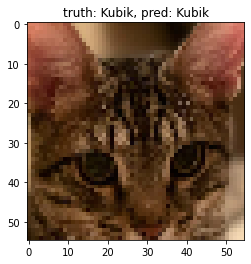

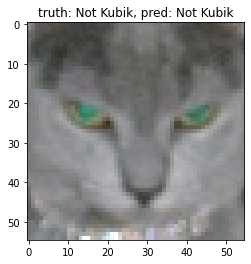

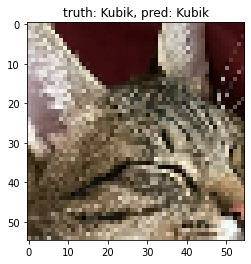

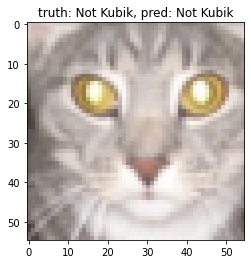

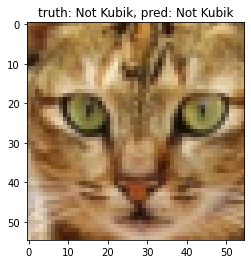

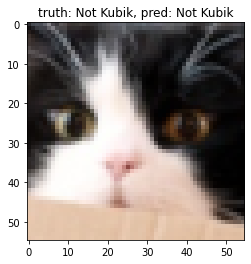

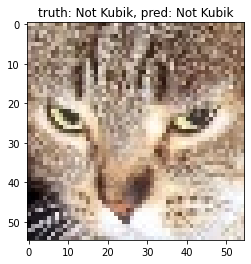

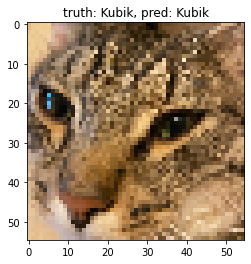

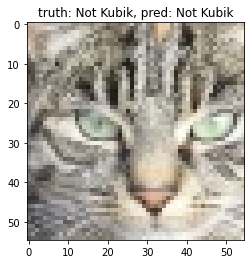

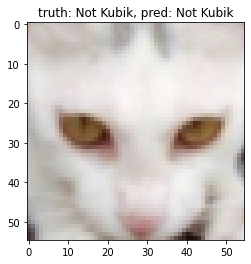

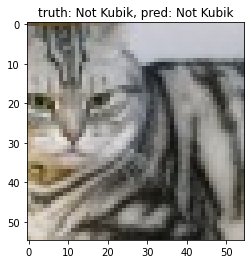

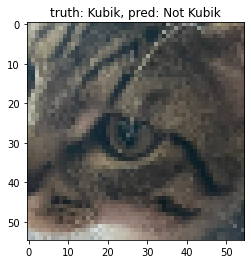

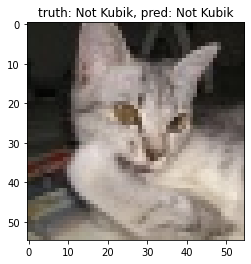

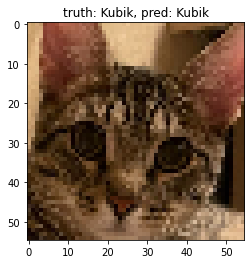

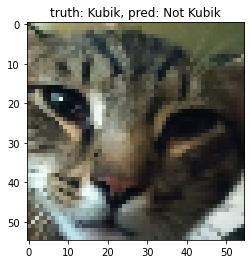

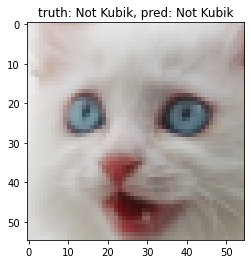

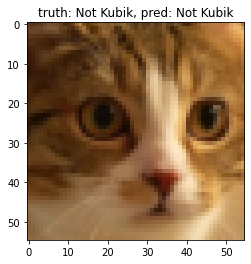

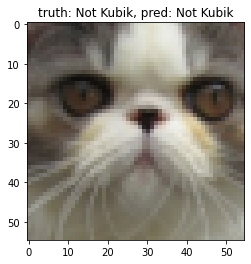

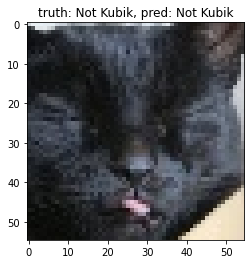

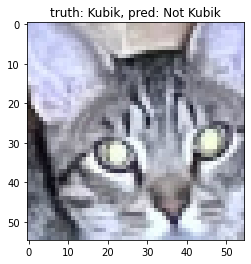

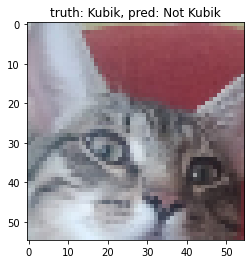

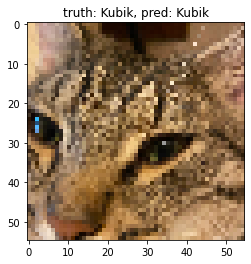

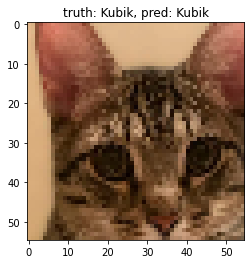

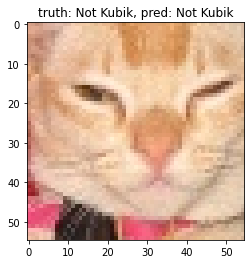

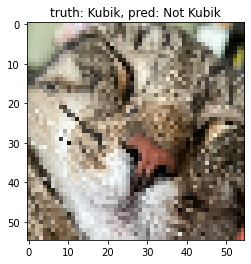

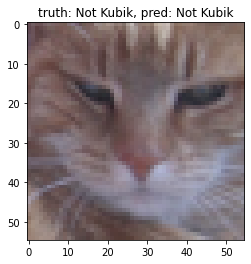

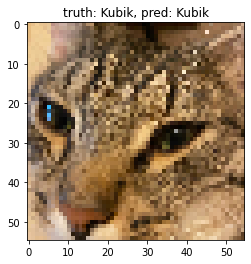

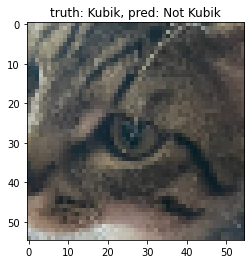

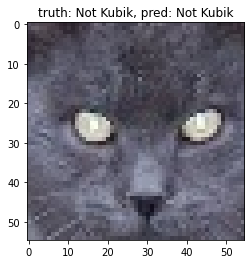

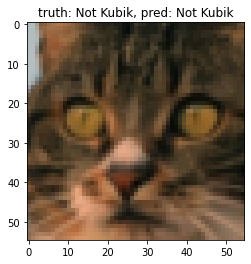

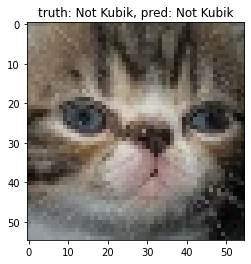

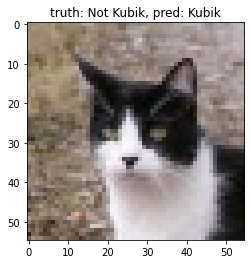

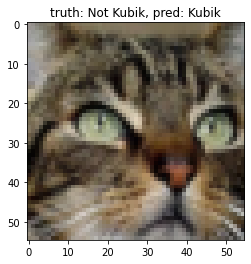

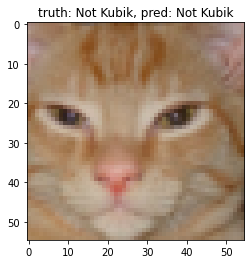

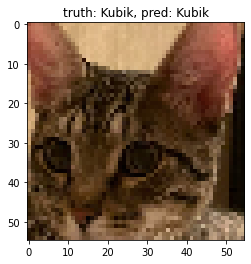

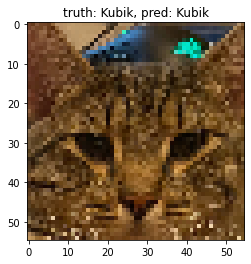

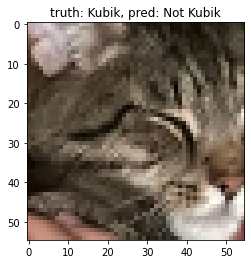

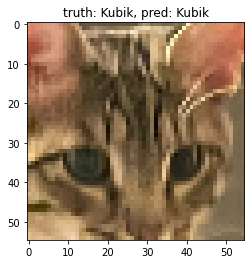

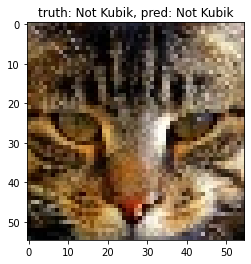

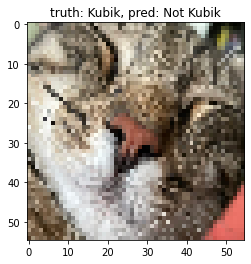

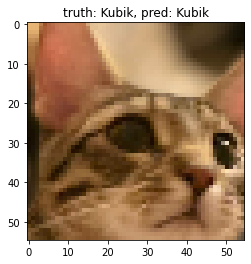

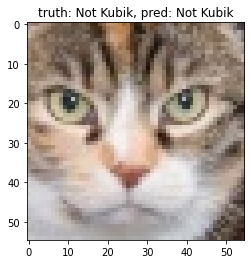

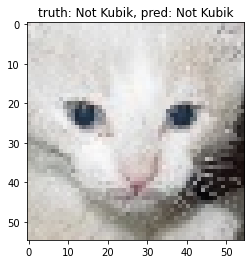

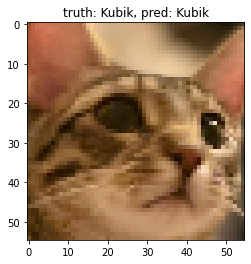

In [82]:
for index, cat in enumerate(data):
    plot_image(torch.Tensor.cpu(cat), labels[index], y_pred[index])